# Computational Biology Seminar
## Project 2: Genomics

The goal for this project is to do a genome-wide association study (GWAS) using a mock dataset (since the real datasets required for this typically aren't publicly available).

In [29]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

### **Step 1:** Reading in the data

In our mock dataset, there is a row for each SNP. For each row, the first three columns contain the information about the SNP: snp_id (chromosome number and position), the reference nucleotide, and the variant nucleotide. 

Then, there are 200 columns, corresponding to the 200 samples labeled in the heading row. The first 100 are the control samples (those that didn't turn into zombies). The next 100 are the "case" samples -- those that did turn into zombies. For each SNP, the column for each samples contains a 0, 1, or 2. This tells us whether that person was homozygous for the reference nucleotide (0), heterozygous (1), or homozygous for the variant nucleotide.

To start, let's read in all this data. We'll store the first three columns in a list called `snp_info`, and the rest in a list of lists called `data`.

In [30]:
snp_info = []
data = []
with open("data/example_data.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')

    for row in reader:

        snp_info.append(row[0:3])
        data.append(row[3:])

The first row was the column headings, so we'll remove that from both `snp_info` and `data` and store it separately.

In [31]:
snp_header = snp_info[0]
snp_info = snp_info[1:]

samples = data[0]
data = data[1:]

Next, we'll cast all these lists to NumPy arrays to make them easier to work with. And remember, we need to cast the elements in `data` to ints since they were read in as strings by default.

In [32]:
snp_info = np.array(snp_info)
data = np.array(data).astype(int)

snp_header = np.array(snp_header)
samples = np.array(samples)

Quick shape check...

In [33]:
print(snp_info.shape)
print(data.shape)
print()
print(snp_header.shape)
print(samples.shape)

(48752, 3)
(48752, 200)

(3,)
(200,)


Quick content check...

In [34]:
print("snp_header:")
print(snp_header)
print()

print("samples:")
print(samples[0:4])
print()

print("snp_info:")
print(snp_info[0:5])
print()

print("data:")
print(data[0:5,0:4])
print()

snp_header:
['snp_id' 'ref' 'var']

samples:
['normal_1' 'normal_2' 'normal_3' 'normal_4']

snp_info:
[['chr1:944564' 'T' 'C']
 ['chr1:950243' 'A' 'C']
 ['chr1:959842' 'C' 'T']
 ['chr1:990417' 'T' 'C']
 ['chr1:1297065' 'C' 'T']]

data:
[[0 1 1 1]
 [2 2 1 1]
 [1 2 1 2]
 [0 2 2 2]
 [2 1 0 1]]



Next we want to make an array with the case/control (zombie/normal) labels for each sample. We can do this with some pretty basic string manipulation.

In [35]:
labels = []

for i in range(len(samples)):
    tmp = samples[i].split("_")
    labels.append(tmp[0])
    
labels = np.array(labels)

Quick checks...

In [36]:
print(labels[0:5])

print(set(labels))

['normal' 'normal' 'normal' 'normal' 'normal']
{'normal', 'zombie'}


### **Step 2:** Filtering SNPs

Before doing the GWAS analysis, we'll filter down our list of SNPs a bit and keep only the ones that have sufficient representation of both the reference and variant alleles, since these are the ones that will be interesting to look at.

To do this, we'll calculate the **minor allele frequency (MAF)** for each SNP. Note: "minor allele" here just means the less common allele of the two, and can be either the reference or variant allele. Before we do the filter, let's practice calculating this number for just the first SNP.

In [37]:
first_snp = data[0,:]

print(first_snp)

[0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 2 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 2 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]


To get the MAF, we'll need the total count of all alleles for the SNP. Since every sample has 2 alleles, we can get this by multiplying the number of samples by 2. This should give us 400.

In [38]:
total_alleles_per_snp = len(samples)*2

print(total_alleles_per_snp)

400


Next, we need the reference allele count for the first SNP. Remember, if a sample is labeled with `0`, that means it has 2 copies of the reference allele ("homozygous" for the reference allele). If it's labeled with `1`, that means it has 1 copy of the reference allele ("heterozygous"). So we can get the reference allele count for the first SNP like this:

In [39]:
ref_allele_count = 2 * np.sum(first_snp == 0) + np.sum(first_snp == 1)

print(ref_allele_count)

342


Now we'll get the variant allele count. If a sample is labeled with `2`, that means it has 2 copies of the variant allele ("homozygous" for the variant allele), and if it's labeled with `1`, that means it has 1 copy ("heterozygous").

In [40]:
var_allele_count = 2 * np.sum(first_snp == 2) + np.sum(first_snp == 1)

print(var_allele_count)

58


Now we'll compute the minor allele frequency. Remember, "minor allele" just means the less common one, and it can be either the reference allele or the variant allele. So we'll use `min(ref_allele_count, var_allele_count)` to select the less common of the two, and then divide by `total_alleles_per_snp` to get the frequency.

In [41]:
maf = min(ref_allele_count, var_allele_count) / total_alleles_per_snp

print(maf)

0.145


Ok! Now that we have our minor allele frequency, we can decide to keep or filter out the SNP, based on whether or not it passes a threshold that we set. Common thresholds are `0.01` or `0.05`, so using either one of those we'd end up keeping this SNP.

Now we can go through and do this calculation for every SNP, and keep a record of the ones that pass the threshold, which we'll set to `0.05`.

In [42]:
maf_threshold = 0.05
total_alleles_per_snp = len(samples)*2


to_keep = []

for i in range(data.shape[0]):
    
    ref_allele_count = 2 * np.sum(data[i,:] == 0) + np.sum(data[i,:] == 1)
    var_allele_count = 2 * np.sum(data[i,:] == 2) + np.sum(data[i,:] == 1)

    maf = min(ref_allele_count, var_allele_count) / total_alleles_per_snp

    if maf >= maf_threshold:
        to_keep.append(True)
    else:
        to_keep.append(False)

Now we apply the filter:

In [43]:
to_keep = np.array(to_keep)

filtered_snp_info = snp_info[to_keep,:]
filtered_data = data[to_keep,:]


print("shape checks:")
print(filtered_snp_info.shape)
print(filtered_data.shape)
print()

print(f"Percent kept: {filtered_data.shape[0] / data.shape[0] * 100}")

shape checks:
(43908, 3)
(43908, 200)

Percent kept: 90.06399737446668


### **Step 3:** GWAS analysis

Now, we'll check each SNP to see if its distribution differs significantly between the zombie/normal phenotypes. To do this, we'll use the [chi-squared test.](https://en.wikipedia.org/wiki/Chi-squared_test) If you're not familiar with this test, I recommend checking out these Khan Academy videos to learn about it: [video 1,](https://www.youtube.com/watch?v=dXB3cUGnaxQ) [video 2,](https://www.youtube.com/watch?v=2QeDRsxSF9M) and [video 3.](https://www.youtube.com/watch?v=hpWdDmgsIRE) To do this, we'll use the `chi2_contingency` function that we imported from `scipy.stats` at the top.

To start, we're going to convert our `labels` array to a binary array, where 1 means "zombie" and 0 means "normal". This will make some of the following steps easier. Here's how we do that:

In [45]:
encoded_labels = np.where(labels == "zombie", 1, 0)

print(encoded_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Now, let's try out this statistical test on just the first SNP, to make sure it's working properly. We'll start by getting all the genotypes for that SNP like this:

In [46]:
snp_genotypes = filtered_data[0, :]

Remember, this tells us whether each sample was homozygous for the reference nucleotide (0), heterozygous (1), or homozygous for the variant nucleotide (2), for all 200 of of samples. Let's take a look.

In [47]:
print(snp_genotypes)

[0 1 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 2 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 2 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]


Next, we'll fill something called a *contingency table* for the chi-squared test. Again, if you've never heard of this before, the Khan Academy videos ([video 1,](https://www.youtube.com/watch?v=dXB3cUGnaxQ) [video 2,](https://www.youtube.com/watch?v=2QeDRsxSF9M) [video 3](https://www.youtube.com/watch?v=hpWdDmgsIRE)) do a good job explaining it. But basically, it's a table with a row for every phenotype label (2 in our case - "normal" and "zombie") and a column for every SNP genotype (3 in our case - 0, 1, and 2). Each element tells us how many samples had the phenotype/genotype combination. For example: 


| | Homozygous reference (0) | Heterozygous (1) | Homozygous variant (2) |
| --- | --- | --- | --- |
| **Normal** | 49 | 43 | 8 |
| **Zombie** | 42 | 47 | 11 |

Let's try making a table like this, starting with a 2-dimensional NumPy array of 0s, and filling it up accordingly using the first row of genotype data that we've saved in `snp_genotypes`.

In [48]:
contingency_table = np.zeros((2, 3))
for j in range(len(snp_genotypes)):
    genotype = snp_genotypes[j]
    status = encoded_labels[j]
    
    contingency_table[status, genotype] += 1


print(contingency_table)

[[73. 25.  2.]
 [71. 29.  0.]]


Now, we'll use this contingency table as an input to the `chi2_contingency` function, which will test the null hypothesis that the two phenotypes do not differ in terms of SNP frequency.

In [49]:
chi2, p_value, _, _ = chi2_contingency(contingency_table)


print(p_value)

0.3128482478887089


Ok, looks good! Now we just need to do this for all the SNPs and record the p-values.

In [50]:
p_values = []

for i in range(filtered_data.shape[0]):
    
    snp_genotypes = filtered_data[i, :]

    contingency_table = np.zeros((2, 3))

    for j in range(len(snp_genotypes)):

        genotype = snp_genotypes[j]
        status = encoded_labels[j]

        contingency_table[status, genotype] += 1

    chi2, p_value, _, _ = chi2_contingency(contingency_table)

    p_values.append(p_value)


ValueError: The internally computed table of expected frequencies has a zero element at (0, 0).

Oh no! This gave us an error! That's because for one of the SNPs, the continency table had a column that was all 0s -- meaning that one of the genotype possibilities (0, 1, or 2) was not found at all in either of the conditions. Unfortunately the `chi2_contingency` function doesn't work when one of the columns is all 0s.

To deal with this, we'll use a little trick, similar to the *epsilon* trick we used in the transcriptomics project to avoid a division-by-zero error. Whenever we run into a SNP that has this problem of a zeros-column, we'll simply add 1 to every element in the contingency table.

Is it ok to do this? Well, that depends on what our goal is. If we were pure mathematicians trying to write a solid proof, then this would *not* be ok, because when we use this trick for a SNP the result won't really be a true p-value. But our goal here isn't to write a pure math proof, it's to investigate the relationship between these SNPs and the phenotypes. So it really comes down to a judgement call, and in this case I think it's ok to do as long as we document that we're doing it so as to not misrepresent the results.

Here's what the new code looks like, applying this trick to avoid the error:

In [54]:
p_values = []

for i in range(filtered_data.shape[0]):
  
    snp_genotypes = filtered_data[i, :]

    contingency_table = np.zeros((2, 3))

    for j in range(len(snp_genotypes)):

        genotype = snp_genotypes[j]
        status = encoded_labels[j]

        contingency_table[status, genotype] += 1

    try:
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        
    except:
        
        # adding 1 to every element to deal with zero-column problem
        contingency_table = contingency_table + 1
        chi2, p_value, _, _ = chi2_contingency(contingency_table)


    p_values.append(p_value)

Now we'll convert our `p_values` list to a NumPy array, to make it easier to work with.

In [55]:
p_values = np.array(p_values)

Next we'll do a [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction), multiplying each p-value by the number of tests we did. [Here's a great comic explaining why this is necessary.](https://xkcd.com/882/)

In [53]:
p_values_bonf = p_values * filtered_data.shape[0]

Now we can check to see if any SNPs came up statistically significant, after the Bonferroni correction.

In [56]:
print(filtered_snp_info[p_values_bonf <= 0.05, ])

[['chr1:221240797' 'G' 'A']
 ['chr2:25491016' 'T' 'C']
 ['chr2:27677691' 'G' 'A']
 ['chr2:217890643' 'A' 'G']
 ['chr2:239567125' 'T' 'C']
 ['chr3:52739520' 'T' 'C']
 ['chr5:42582527' 'C' 'T']
 ['chr5:102282317' 'C' 'T']
 ['chr5:179729519' 'A' 'G']
 ['chr6:28169158' 'T' 'A']
 ['chr6:140688409' 'A' 'G']
 ['chr7:92657985' 'A' 'G']
 ['chr7:135262533' 'T' 'C']
 ['chr9:89081586' 'A' 'G']
 ['chr9:119176250' 'T' 'C']
 ['chr10:121124501' 'A' 'G']
 ['chr11:1890990' 'G' 'A']
 ['chr11:85436868' 'G' 'C']
 ['chr11:119054488' 'C' 'T']
 ['chr12:66359752' 'C' 'A']
 ['chr14:70469255' 'A' 'C']
 ['chr15:45526391' 'T' 'G']
 ['chr15:66051299' 'C' 'T']
 ['chr15:85171495' 'A' 'C']
 ['chr15:86159953' 'G' 'A']
 ['chr15:90113932' 'C' 'T']
 ['chr18:41427543' 'G' 'T']
 ['chr20:42279727' 'C' 'T']
 ['chr20:48597659' 'A' 'G']
 ['chr22:43116307' 'G' 'T']]


### **Step 4:** Manhattan Plot

Now we'll make a Manhattan plot to visualize these results. First, we'll parse the *snp_ids* to separate the chromosome numbers and positions, and cast them to ints.

In [58]:
filtered_snp_chromosomes = []
filtered_snp_positions = []


for i in range(filtered_snp_info.shape[0]):
    
    snp_id = filtered_snp_info[i,0]
    
    chromosome, position = snp_id.split(":")
    
    chromosome = chromosome.replace('chr', '')
    
    chromosome = int(chromosome)
    position = int(position)
    
    
    filtered_snp_chromosomes.append(chromosome)
    filtered_snp_positions.append(position)
    
    
filtered_snp_chromosomes = np.array(filtered_snp_chromosomes)
filtered_snp_positions = np.array(filtered_snp_positions)

Next, we'll take the negative log of the raw p-values, so that the lowest p-values will be high positive numbers.

In [60]:
neg_log_p_values = -np.log10(p_values)

This is a pretty tricky plot to make, so I found it easiest to just use ChatGPT. My rule with ChatGPT is to only use it for things where I can immediately check if it's getting it right or not, like plotting and string manipulation.

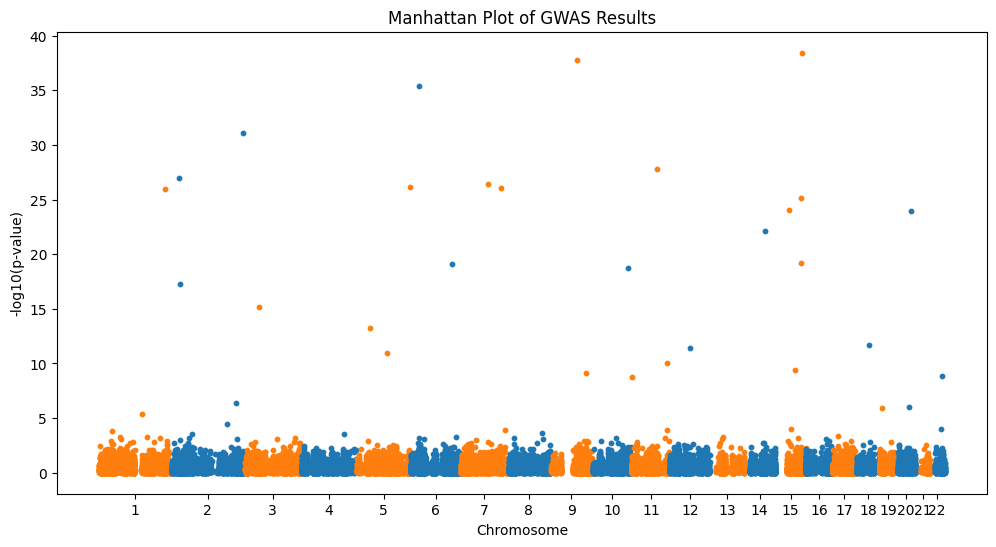

In [61]:
# Create a DataFrame-like structure using NumPy
snp_data = np.column_stack((filtered_snp_chromosomes, filtered_snp_positions, neg_log_p_values))

# Sort the data by chromosome and position
snp_data = snp_data[np.lexsort((snp_data[:, 1], snp_data[:, 0]))]

# Compute cumulative positions
cumulative_positions = np.zeros_like(filtered_snp_positions)
chromosome_offsets = {}
midpoints = []

current_offset = 0
for chromosome in np.unique(filtered_snp_chromosomes):
    chrom_mask = filtered_snp_chromosomes == chromosome
    chromosome_offsets[chromosome] = current_offset
    cumulative_positions[chrom_mask] = filtered_snp_positions[chrom_mask] + current_offset
    midpoints.append((current_offset + np.max(cumulative_positions[chrom_mask])) / 2)
    current_offset += np.max(filtered_snp_positions[chrom_mask]) + 1  # Add a buffer between chromosomes

# Prepare the Manhattan plot
plt.figure(figsize=(12, 6))

# Define colors for different chromosomes
colors = ['#1f77b4', '#ff7f0e']

# Plot each chromosome with alternating colors and smaller dots
dot_size = 10  # Adjust this value to change the size of the dots
current_chromosome = 1
for chromosome in np.unique(snp_data[:, 0]):
    chrom_mask = snp_data[:, 0] == chromosome
    plt.scatter(cumulative_positions[chrom_mask], snp_data[chrom_mask, 2], c=colors[current_chromosome % 2], s=dot_size, label=f'Chromosome {chromosome}')
    current_chromosome += 1

# Add chromosome labels at midpoints
plt.xticks(midpoints, np.unique(filtered_snp_chromosomes))

# Add labels and title
plt.xlabel('Chromosome')
plt.ylabel('-log10(p-value)')
plt.title('Manhattan Plot of GWAS Results')
# plt.legend()

# Show the plot
plt.savefig("output/manhattan_plot.pdf")

plt.show()